# Windows Logic Reproduction with Pulse Propagation Lattice

This notebook trains a pulse propagation lattice model to learn and reproduce the logic
of Windows batch scripts using Dolma embeddings.

## Overview
1. Load Dolma embeddings (300-dimensional word vectors)
2. Tokenize Windows batch files using Dolma vocabulary
3. Load best pulse propagation configuration from search
4. Train lattice model to predict program logic sequences
5. Evaluate reproduction quality

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from pathlib import Path
from tqdm.auto import tqdm
import json
import re
from collections import defaultdict

# Local imports
from tensor_lattice import Tensor3DLattice, DifferentiableTensor3DLattice
from lattice_patterns import PatternGenerator, Pattern3D

# Device setup
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: mps


## 1. Configuration

In [2]:
# Paths
DOLMA_PATH = Path('training/dolma_300_2024_1.2M.100_combined.txt')
WINDOWS_PATH = Path('training/windows_training/nano11builder-main')

# Model configuration
EMBEDDING_DIM = 300  # Dolma embedding dimension
LATTICE_SHAPE = (12, 12, 12)
HIDDEN_DIM = 256
CONTEXT_LENGTH = 64  # Sequence context window

# Training configuration
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 50
MAX_VOCAB_SIZE = 50000  # Limit vocabulary for memory

print(f"Embedding dim: {EMBEDDING_DIM}")
print(f"Lattice shape: {LATTICE_SHAPE}")
print(f"Context length: {CONTEXT_LENGTH}")

Embedding dim: 300
Lattice shape: (12, 12, 12)
Context length: 64


## 2. Load Dolma Embeddings

In [3]:
class DolmaEmbeddings:
    """Loader for Dolma word embeddings."""
    
    def __init__(self, path: Path, max_vocab: int = 50000):
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.embeddings = []
        
        print(f"Loading Dolma embeddings from {path}...")
        
        with open(path, 'r', encoding='utf-8', errors='ignore') as f:
            for i, line in enumerate(tqdm(f, desc="Loading", total=max_vocab)):
                if i >= max_vocab:
                    break
                
                parts = line.strip().split(' ')
                if len(parts) < EMBEDDING_DIM + 1:
                    continue
                
                word = parts[0]
                try:
                    vector = [float(x) for x in parts[1:EMBEDDING_DIM+1]]
                except ValueError:
                    continue
                
                self.word_to_idx[word] = len(self.embeddings)
                self.idx_to_word[len(self.embeddings)] = word
                self.embeddings.append(vector)
        
        # Convert to tensor
        self.embeddings = torch.tensor(self.embeddings, dtype=torch.float32)
        
        # Add special tokens
        self._add_special_tokens()
        
        print(f"Loaded {len(self.word_to_idx)} words, embedding shape: {self.embeddings.shape}")
    
    def _add_special_tokens(self):
        """Add special tokens for unknown, padding, start, end."""
        special = ['<PAD>', '<UNK>', '<START>', '<END>', '<NEWLINE>']
        
        for token in special:
            if token not in self.word_to_idx:
                idx = len(self.embeddings)
                self.word_to_idx[token] = idx
                self.idx_to_word[idx] = token
                # Random embedding for special tokens
                new_emb = torch.randn(1, EMBEDDING_DIM) * 0.1
                self.embeddings = torch.cat([self.embeddings, new_emb], dim=0)
        
        self.pad_idx = self.word_to_idx['<PAD>']
        self.unk_idx = self.word_to_idx['<UNK>']
        self.start_idx = self.word_to_idx['<START>']
        self.end_idx = self.word_to_idx['<END>']
        self.newline_idx = self.word_to_idx['<NEWLINE>']
    
    def tokenize(self, text: str) -> List[int]:
        """Tokenize text into word indices."""
        # Simple whitespace + punctuation tokenization
        tokens = re.findall(r'\w+|[^\w\s]|\n', text.lower())
        indices = []
        
        for token in tokens:
            if token == '\n':
                indices.append(self.newline_idx)
            elif token in self.word_to_idx:
                indices.append(self.word_to_idx[token])
            else:
                indices.append(self.unk_idx)
        
        return indices
    
    def decode(self, indices: List[int]) -> str:
        """Decode indices back to text."""
        words = []
        for idx in indices:
            if idx == self.newline_idx:
                words.append('\n')
            elif idx == self.pad_idx:
                continue
            else:
                words.append(self.idx_to_word.get(idx, '<UNK>'))
        return ' '.join(words)
    
    def get_embedding(self, indices: torch.Tensor) -> torch.Tensor:
        """Get embeddings for token indices."""
        return self.embeddings[indices]


# Load embeddings
dolma = DolmaEmbeddings(DOLMA_PATH, max_vocab=MAX_VOCAB_SIZE)

Loading Dolma embeddings from training/dolma_300_2024_1.2M.100_combined.txt...


Loading:   0%|          | 0/50000 [00:00<?, ?it/s]

Loaded 50005 words, embedding shape: torch.Size([50005, 300])


## 3. Load and Tokenize Windows Files

In [4]:
def load_windows_files(path: Path) -> Dict[str, str]:
    """Load text content from Windows batch files."""
    files = {}
    
    for ext in ['*.bat', '*.xml', '*.md']:
        for file_path in path.glob(ext):
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                files[file_path.name] = content
                print(f"Loaded {file_path.name}: {len(content)} chars")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    return files


# Load Windows files
windows_files = load_windows_files(WINDOWS_PATH)
print(f"\nLoaded {len(windows_files)} files")

Loaded nano11builder_copilot.bat: 13513 chars
Loaded Nano11Builder.bat: 13756 chars
Loaded autounattend.xml: 1632 chars
Loaded README.md: 1262 chars

Loaded 4 files


In [5]:
def create_training_sequences(files: Dict[str, str], dolma: DolmaEmbeddings,
                              context_length: int = 64) -> Tuple[torch.Tensor, torch.Tensor]:
    """Create training sequences from tokenized files."""
    all_tokens = []
    
    for name, content in files.items():
        tokens = dolma.tokenize(content)
        all_tokens.extend([dolma.start_idx] + tokens + [dolma.end_idx])
    
    print(f"Total tokens: {len(all_tokens)}")
    
    # Create input-target pairs with sliding window
    inputs = []
    targets = []
    
    for i in range(0, len(all_tokens) - context_length - 1, context_length // 2):
        input_seq = all_tokens[i:i + context_length]
        target_seq = all_tokens[i + 1:i + context_length + 1]
        
        # Pad if needed
        while len(input_seq) < context_length:
            input_seq.append(dolma.pad_idx)
            target_seq.append(dolma.pad_idx)
        
        inputs.append(input_seq)
        targets.append(target_seq)
    
    inputs = torch.tensor(inputs, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    
    print(f"Created {len(inputs)} training sequences")
    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    
    return inputs, targets


# Create training data
train_inputs, train_targets = create_training_sequences(
    windows_files, dolma, CONTEXT_LENGTH
)

Total tokens: 8231
Created 256 training sequences
Input shape: torch.Size([256, 64]), Target shape: torch.Size([256, 64])


In [6]:
# Analyze token distribution
unique_tokens = torch.unique(train_inputs)
print(f"Unique tokens in training data: {len(unique_tokens)}")

# Count token frequencies
token_counts = defaultdict(int)
for seq in train_inputs:
    for token in seq.tolist():
        token_counts[token] += 1

# Most common tokens
sorted_tokens = sorted(token_counts.items(), key=lambda x: -x[1])[:20]
print("\nMost common tokens:")
for idx, count in sorted_tokens:
    word = dolma.idx_to_word.get(idx, f'<{idx}>')
    print(f"  {word}: {count}")

Unique tokens in training data: 355

Most common tokens:
  <UNK>: 2616
  \: 1298
  /: 1278
  <NEWLINE>: 1049
  .: 1013
  ": 986
  :: 766
  >: 549
  -: 370
  echo: 318
  c: 296
  1: 270
  image: 241
  reg: 226
  microsoft: 208
  2: 206
  windows: 194
  &: 184
  t: 161
  ~: 152


## 4. Load Pulse Propagation Configuration

In [7]:
@dataclass
class PropagationType:
    """Configuration for pulse propagation."""
    name: str
    n_steps: int
    decay_rate: float
    bounce_strength: float
    diffusion_rate: float
    self_retention: float
    nonlinearity: str


# Try to load from search results, otherwise use defaults
try:
    with open('pulse_search_results.json', 'r') as f:
        results = json.load(f)
    
    best_config = results['best']['propagation_config']
    best_pattern_name = results['best']['pattern']
    
    PROPAGATION = PropagationType(
        name=results['best']['propagation'],
        n_steps=best_config['n_steps'],
        decay_rate=best_config['decay_rate'],
        bounce_strength=best_config['bounce_strength'],
        diffusion_rate=best_config['diffusion_rate'],
        self_retention=best_config['self_retention'],
        nonlinearity=best_config['nonlinearity']
    )
    
    # Load best pattern
    best_pattern_data = np.load('best_pulse_pattern.npy')
    print(f"Loaded best configuration from search:")
    print(f"  Pattern: {best_pattern_name}")
    print(f"  Propagation: {PROPAGATION.name}")
    
except FileNotFoundError:
    print("No search results found, using default configuration")
    
    # Default propagation
    PROPAGATION = PropagationType(
        name='diffuse',
        n_steps=5,
        decay_rate=0.85,
        bounce_strength=0.3,
        diffusion_rate=0.5,
        self_retention=0.5,
        nonlinearity='tanh'
    )
    
    # Create default pattern
    pg = PatternGenerator(shape=LATTICE_SHAPE)
    best_pattern_data = pg.radial_gradient().data
    best_pattern_name = 'radial_gradient'

print(f"\nPropagation config:")
print(f"  Steps: {PROPAGATION.n_steps}")
print(f"  Decay: {PROPAGATION.decay_rate}")
print(f"  Diffusion: {PROPAGATION.diffusion_rate}")

Loaded best configuration from search:
  Pattern: shell
  Propagation: wave

Propagation config:
  Steps: 8
  Decay: 0.9
  Diffusion: 0.6


## 5. Pulse Propagation Language Model

In [8]:
class PulsePropagationLattice(nn.Module):
    """Lattice with configurable pulse propagation."""
    
    def __init__(self, shape: Tuple[int, ...], topology: str = 'toroidal'):
        super().__init__()
        self.shape = shape
        self.n_cells = np.prod(shape)
        self.register_buffer('adjacency', self._build_adjacency(shape, topology))
    
    def _build_adjacency(self, shape: Tuple[int, ...], topology: str) -> torch.Tensor:
        """Build normalized adjacency matrix."""
        d1, d2, d3 = shape
        n_cells = d1 * d2 * d3
        adjacency = torch.zeros(n_cells, n_cells)
        
        offsets = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]
        
        for x in range(d1):
            for y in range(d2):
                for z in range(d3):
                    idx = x * d2 * d3 + y * d3 + z
                    
                    for dx, dy, dz in offsets:
                        if topology == 'toroidal':
                            nx, ny, nz = (x+dx) % d1, (y+dy) % d2, (z+dz) % d3
                        else:
                            nx, ny, nz = x+dx, y+dy, z+dz
                            if not (0 <= nx < d1 and 0 <= ny < d2 and 0 <= nz < d3):
                                continue
                        
                        neighbor_idx = nx * d2 * d3 + ny * d3 + nz
                        adjacency[idx, neighbor_idx] = 1.0
        
        row_sums = adjacency.sum(dim=1, keepdim=True).clamp(min=1)
        return adjacency / row_sums
    
    def propagate(self, state: torch.Tensor, prop: PropagationType,
                  pattern_weights: torch.Tensor) -> torch.Tensor:
        """Propagate signal through lattice."""
        if prop.n_steps == 0:
            return state * pattern_weights
        
        state = state * pattern_weights
        
        for _ in range(prop.n_steps):
            diffused = torch.matmul(state, self.adjacency.T)
            state = prop.self_retention * state + prop.diffusion_rate * diffused
            state = state * prop.decay_rate
            
            if prop.bounce_strength > 0:
                bounce = 1.0 + prop.bounce_strength * (pattern_weights - 0.5)
                state = state * bounce
            
            if prop.nonlinearity == 'relu':
                state = F.relu(state)
            elif prop.nonlinearity == 'tanh':
                state = torch.tanh(state)
            elif prop.nonlinearity == 'sigmoid':
                state = torch.sigmoid(state)
        
        return state


class WindowsLogicModel(nn.Module):
    """Language model for Windows batch file logic using pulse propagation."""
    
    def __init__(self, vocab_size: int, embedding_dim: int, 
                 lattice_shape: Tuple[int, ...], hidden_dim: int,
                 pretrained_embeddings: torch.Tensor = None,
                 pattern_weights: np.ndarray = None,
                 prop_type: PropagationType = None):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lattice_shape = lattice_shape
        self.n_cells = np.prod(lattice_shape)
        self.prop_type = prop_type
        
        # Embedding layer (initialize with pretrained if available)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        # Positional encoding
        self.pos_encoding = nn.Embedding(CONTEXT_LENGTH, embedding_dim)
        
        # Project sequence to lattice
        self.seq_to_lattice = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, self.n_cells),
            nn.Sigmoid()
        )
        
        # Lattice with propagation
        self.lattice = PulsePropagationLattice(lattice_shape)
        
        # Pattern weights
        if pattern_weights is not None:
            pw = torch.from_numpy(pattern_weights).float().flatten()
        else:
            pw = torch.ones(self.n_cells)
        self.register_buffer('pattern_weights', pw)
        
        # Context aggregation (attention over sequence)
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads=4, batch_first=True)
        
        # Decode propagated lattice to output
        self.lattice_to_hidden = nn.Sequential(
            nn.Linear(self.n_cells, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
        )
        
        # Output projection (per position)
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim + embedding_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, vocab_size)
        )
    
    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        """Forward pass predicting next tokens."""
        batch_size, seq_len = input_ids.shape
        
        # Get embeddings
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)
        embeddings = self.embedding(input_ids) + self.pos_encoding(positions)
        
        # Self-attention for context
        # Causal mask for autoregressive prediction
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=input_ids.device), diagonal=1).bool()
        attended, _ = self.attention(embeddings, embeddings, embeddings, attn_mask=causal_mask)
        
        # Process each position through lattice
        outputs = []
        
        for t in range(seq_len):
            # Context up to position t
            context = attended[:, t, :]  # (batch, embedding_dim)
            
            # Project to lattice
            lattice_state = self.seq_to_lattice(context)  # (batch, n_cells)
            
            # Propagate through lattice
            propagated = self.lattice.propagate(
                lattice_state, self.prop_type, self.pattern_weights
            )
            
            # Decode
            lattice_features = self.lattice_to_hidden(propagated)  # (batch, hidden)
            
            # Combine with embedding context
            combined = torch.cat([lattice_features, context], dim=-1)
            logits = self.output_proj(combined)  # (batch, vocab_size)
            outputs.append(logits)
        
        # Stack outputs: (batch, seq_len, vocab_size)
        return torch.stack(outputs, dim=1)
    
    def generate(self, start_tokens: torch.Tensor, max_length: int = 100,
                 temperature: float = 1.0) -> torch.Tensor:
        """Generate tokens autoregressively."""
        self.eval()
        generated = start_tokens.clone()
        
        with torch.no_grad():
            for _ in range(max_length):
                # Get context window
                context = generated[:, -CONTEXT_LENGTH:]
                if context.shape[1] < CONTEXT_LENGTH:
                    # Pad at the beginning
                    pad = torch.full((context.shape[0], CONTEXT_LENGTH - context.shape[1]),
                                    dolma.pad_idx, device=context.device)
                    context = torch.cat([pad, context], dim=1)
                
                # Get predictions
                logits = self(context)
                next_logits = logits[:, -1, :] / temperature
                
                # Sample
                probs = F.softmax(next_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                generated = torch.cat([generated, next_token], dim=1)
                
                # Stop at end token
                if (next_token == dolma.end_idx).all():
                    break
        
        return generated


print("Model classes defined!")

Model classes defined!


In [9]:
# Create model
model = WindowsLogicModel(
    vocab_size=len(dolma.word_to_idx),
    embedding_dim=EMBEDDING_DIM,
    lattice_shape=LATTICE_SHAPE,
    hidden_dim=HIDDEN_DIM,
    pretrained_embeddings=dolma.embeddings,
    pattern_weights=best_pattern_data,
    prop_type=PROPAGATION
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 29,341,089
Trainable parameters: 14,339,589


## 6. Training

In [10]:
def train_epoch(model, inputs, targets, optimizer, scheduler=None):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    n_batches = 0
    
    indices = torch.randperm(len(inputs))
    
    for i in range(0, len(inputs), BATCH_SIZE):
        batch_idx = indices[i:i+BATCH_SIZE]
        batch_inputs = inputs[batch_idx].to(device)
        batch_targets = targets[batch_idx].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch_inputs)
        
        # Compute loss (ignore padding)
        loss = F.cross_entropy(
            logits.view(-1, model.vocab_size),
            batch_targets.view(-1),
            ignore_index=dolma.pad_idx
        )
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    if scheduler is not None:
        scheduler.step()
    
    return total_loss / n_batches


def evaluate_model(model, inputs, targets):
    """Evaluate model on data."""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    with torch.no_grad():
        for i in range(0, len(inputs), BATCH_SIZE):
            batch_inputs = inputs[i:i+BATCH_SIZE].to(device)
            batch_targets = targets[i:i+BATCH_SIZE].to(device)
            
            logits = model(batch_inputs)
            
            loss = F.cross_entropy(
                logits.view(-1, model.vocab_size),
                batch_targets.view(-1),
                ignore_index=dolma.pad_idx
            )
            
            # Compute accuracy
            predictions = logits.argmax(dim=-1)
            mask = batch_targets != dolma.pad_idx
            correct = ((predictions == batch_targets) & mask).sum().item()
            
            total_loss += loss.item() * batch_inputs.shape[0]
            total_correct += correct
            total_tokens += mask.sum().item()
    
    avg_loss = total_loss / len(inputs)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    perplexity = np.exp(avg_loss)
    
    return {'loss': avg_loss, 'accuracy': accuracy, 'perplexity': perplexity}


print("Training functions defined!")

Training functions defined!


In [11]:
# Setup optimizer and scheduler
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

# Training loop
train_losses = []
train_accuracies = []
train_perplexities = []

print(f"Training for {EPOCHS} epochs...")
print("=" * 60)

for epoch in tqdm(range(EPOCHS), desc="Training"):
    loss = train_epoch(model, train_inputs, train_targets, optimizer, scheduler)
    train_losses.append(loss)
    
    # Evaluate periodically
    if (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:
        metrics = evaluate_model(model, train_inputs, train_targets)
        train_accuracies.append(metrics['accuracy'])
        train_perplexities.append(metrics['perplexity'])
        
        print(f"\nEpoch {epoch+1}/{EPOCHS}:")
        print(f"  Loss: {loss:.4f}")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Perplexity: {metrics['perplexity']:.2f}")

print("\nTraining complete!")

Training for 50 epochs...


Training:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 5/50:
  Loss: 3.5646
  Accuracy: 0.2753
  Perplexity: 29.38

Epoch 10/50:
  Loss: 2.5170
  Accuracy: 0.4225
  Perplexity: 11.36

Epoch 15/50:
  Loss: 2.0494
  Accuracy: 0.4935
  Perplexity: 7.37

Epoch 20/50:
  Loss: 1.7630
  Accuracy: 0.5618
  Perplexity: 5.55

Epoch 25/50:
  Loss: 1.5194
  Accuracy: 0.6316
  Perplexity: 4.38

Epoch 30/50:
  Loss: 1.3358
  Accuracy: 0.6815
  Perplexity: 3.68

Epoch 35/50:
  Loss: 1.2072
  Accuracy: 0.7113
  Perplexity: 3.26

Epoch 40/50:
  Loss: 1.1282
  Accuracy: 0.7267
  Perplexity: 3.05

Epoch 45/50:
  Loss: 1.0892
  Accuracy: 0.7318
  Perplexity: 2.96

Epoch 50/50:
  Loss: 1.0786
  Accuracy: 0.7356
  Perplexity: 2.94

Training complete!


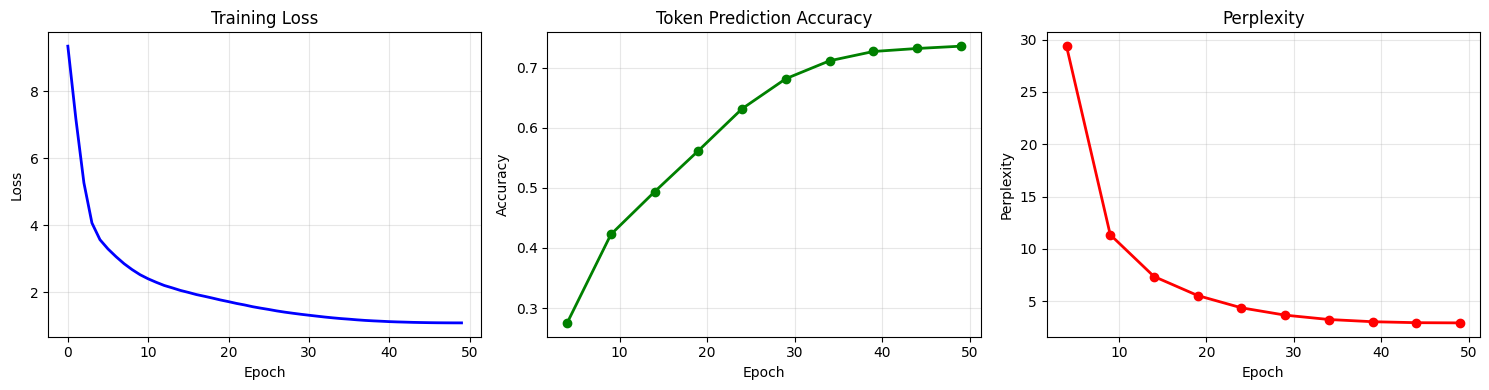

In [12]:
# Plot training progress
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

eval_epochs = list(range(4, len(train_accuracies) * 5, 5))[:len(train_accuracies)]
if len(eval_epochs) < len(train_accuracies):
    eval_epochs = list(range(len(train_accuracies)))
axes[1].plot(eval_epochs, train_accuracies, 'g-o', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Token Prediction Accuracy')
axes[1].grid(True, alpha=0.3)

axes[2].plot(eval_epochs, train_perplexities, 'r-o', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Perplexity')
axes[2].set_title('Perplexity')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/windows_logic_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Evaluate Logic Reproduction

In [13]:
def compute_logic_reproduction_score(model, original_text: str, dolma: DolmaEmbeddings,
                                     num_samples: int = 5) -> Dict[str, float]:
    """Compute how well the model reproduces program logic."""
    model.eval()
    
    # Tokenize original
    original_tokens = [dolma.start_idx] + dolma.tokenize(original_text)
    
    # Generate from the same start
    start_len = min(10, len(original_tokens) // 4)
    start_tokens = torch.tensor([original_tokens[:start_len]], device=device)
    
    # Generate multiple samples
    generated_samples = []
    for _ in range(num_samples):
        generated = model.generate(start_tokens, max_length=len(original_tokens), temperature=0.8)
        generated_samples.append(generated[0].cpu().tolist())
    
    # Compute metrics
    metrics = {
        'exact_match_ratio': 0.0,
        'token_overlap': 0.0,
        'command_accuracy': 0.0,
        'structure_score': 0.0
    }
    
    # Extract commands from original (lines starting with specific keywords)
    original_lines = original_text.lower().split('\n')
    command_keywords = ['echo', 'set', 'dism', 'mkdir', 'del', 'copy', 'xcopy', 'if', 'goto', 'call']
    original_commands = []
    for line in original_lines:
        line = line.strip()
        for kw in command_keywords:
            if line.startswith(kw):
                original_commands.append(kw)
                break
    
    for gen_tokens in generated_samples:
        # Token overlap
        original_set = set(original_tokens)
        gen_set = set(gen_tokens)
        overlap = len(original_set & gen_set) / len(original_set) if original_set else 0
        metrics['token_overlap'] += overlap
        
        # Exact match ratio (position-wise)
        min_len = min(len(original_tokens), len(gen_tokens))
        exact_matches = sum(1 for i in range(min_len) if original_tokens[i] == gen_tokens[i])
        metrics['exact_match_ratio'] += exact_matches / len(original_tokens)
        
        # Decode and check command structure
        gen_text = dolma.decode(gen_tokens)
        gen_lines = gen_text.lower().split('\n')
        
        gen_commands = []
        for line in gen_lines:
            line = line.strip()
            for kw in command_keywords:
                if kw in line[:20]:  # Check near start of line
                    gen_commands.append(kw)
                    break
        
        # Command accuracy
        if original_commands:
            cmd_overlap = len(set(original_commands) & set(gen_commands)) / len(set(original_commands))
            metrics['command_accuracy'] += cmd_overlap
        
        # Structure score (similar line count, command density)
        line_ratio = min(len(gen_lines), len(original_lines)) / max(len(gen_lines), len(original_lines), 1)
        metrics['structure_score'] += line_ratio
    
    # Average over samples
    for key in metrics:
        metrics[key] /= num_samples
    
    # Composite score
    metrics['composite_score'] = (
        0.2 * metrics['exact_match_ratio'] +
        0.2 * metrics['token_overlap'] +
        0.4 * metrics['command_accuracy'] +
        0.2 * metrics['structure_score']
    )
    
    return metrics


print("Evaluation function defined!")

Evaluation function defined!


In [14]:
# Evaluate logic reproduction for each file
print("Evaluating Logic Reproduction")
print("=" * 60)

all_scores = {}

for filename, content in windows_files.items():
    if not filename.endswith('.bat'):
        continue
    
    print(f"\nEvaluating: {filename}")
    scores = compute_logic_reproduction_score(model, content, dolma)
    all_scores[filename] = scores
    
    print(f"  Exact match ratio: {scores['exact_match_ratio']:.4f}")
    print(f"  Token overlap: {scores['token_overlap']:.4f}")
    print(f"  Command accuracy: {scores['command_accuracy']:.4f}")
    print(f"  Structure score: {scores['structure_score']:.4f}")
    print(f"  COMPOSITE SCORE: {scores['composite_score']:.4f}")

Evaluating Logic Reproduction

Evaluating: nano11builder_copilot.bat
  Exact match ratio: 0.0629
  Token overlap: 0.3328
  Command accuracy: 0.2250
  Structure score: 0.7122
  COMPOSITE SCORE: 0.3116

Evaluating: Nano11Builder.bat
  Exact match ratio: 0.0558
  Token overlap: 0.2550
  Command accuracy: 0.2000
  Structure score: 0.5466
  COMPOSITE SCORE: 0.2515


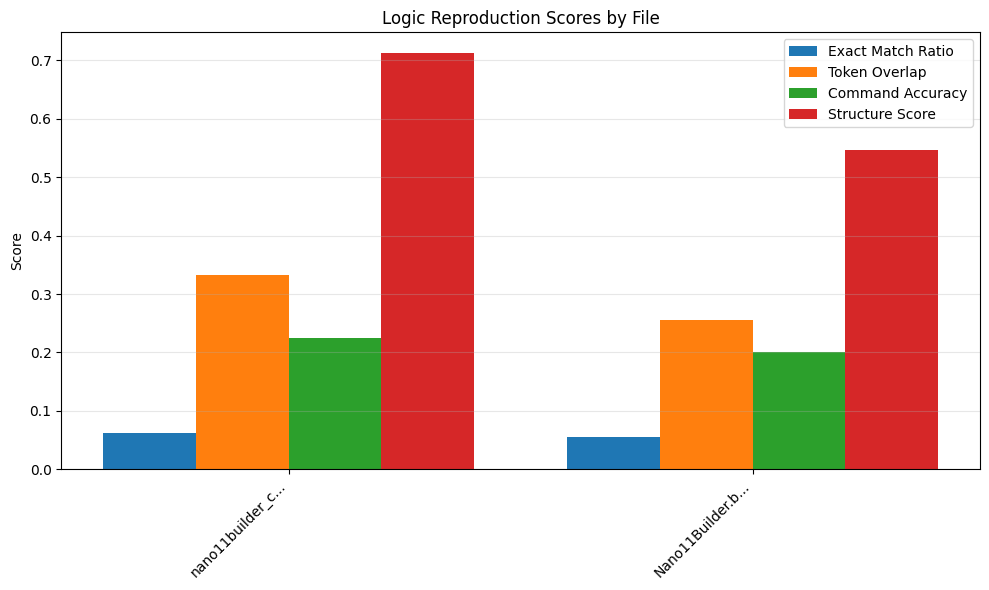


Overall Composite Score: 0.2815


In [19]:
# Visualize scores
if all_scores:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    files = list(all_scores.keys())
    metrics = ['exact_match_ratio', 'token_overlap', 'command_accuracy', 'structure_score']
    
    x = np.arange(len(files))
    width = 0.2
    
    for i, metric in enumerate(metrics):
        values = [all_scores[f][metric] for f in files]
        ax.bar(x + i * width, values, width, label=metric.replace('_', ' ').title())
    
    ax.set_ylabel('Score')
    ax.set_title('Logic Reproduction Scores by File')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels([f[:15] + '...' for f in files], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('images/logic_reproduction_scores.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Overall composite score
    avg_composite = np.mean([s['composite_score'] for s in all_scores.values()])
    print(f"\nOverall Composite Score: {avg_composite:.4f}")

## 8. Generate Sample Output

In [20]:
# Generate a sample continuation
print("Generated Windows Batch Logic")
print("=" * 60)

# Start with common batch file beginning
start_text = "@echo off\nsetlocal\necho"
start_tokens = torch.tensor([[dolma.start_idx] + dolma.tokenize(start_text)], device=device)

print(f"Starting with: {start_text}")
print("-" * 60)

# Generate
generated = model.generate(start_tokens, max_length=200, temperature=0.7)
generated_text = dolma.decode(generated[0].cpu().tolist())

print("Generated:")
print(generated_text[:1000])

Generated Windows Batch Logic
Starting with: @echo off
setlocal
echo
------------------------------------------------------------
Generated:
<START> @ echo off 
 <UNK> 
 echo image image image . . . . . 
 echo removing image iso image . . . . . . . . . . . 
 <UNK> . image . . . . . . . . . 
 <UNK> / image : c : 
 <UNK> . . . . . . 
 <UNK> / export <UNK> . 
 <UNK> / image : c : 
 <UNK> / image : c : \ <UNK> / remove - <UNK> / image : c : microsoft . <UNK> . <UNK> / image : c : \ <UNK> / image : c : \ <UNK> / remove - <UNK> / image : c : \ <UNK> / remove - en - package / <UNK> : \ <UNK> / <UNK> * 
 echo removing microsoft . windows \ <UNK> \ <UNK> / remove - <UNK> * 
 echo <UNK> / remove - <UNK> / remove - <UNK> / image : microsoft . <UNK> * 
 <UNK> / <UNK> / image : c : \ <UNK> / remove - <UNK> . 0 " <UNK> / remove - <UNK> / <UNK> : 
 echo removing <UNK> : microsoft . <UNK> * " <UNK> / <UNK>


## 9. Save Model and Results

In [21]:
# Save model
torch.save(model.state_dict(), 'windows_logic_model.pt')

# Save results
results = {
    'config': {
        'embedding_dim': EMBEDDING_DIM,
        'lattice_shape': LATTICE_SHAPE,
        'hidden_dim': HIDDEN_DIM,
        'context_length': CONTEXT_LENGTH,
        'epochs': EPOCHS,
        'pattern': best_pattern_name,
        'propagation': PROPAGATION.name
    },
    'training': {
        'final_loss': train_losses[-1],
        'final_accuracy': train_accuracies[-1] if train_accuracies else None,
        'final_perplexity': train_perplexities[-1] if train_perplexities else None
    },
    'reproduction_scores': all_scores
}

with open('windows_logic_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Saved:")
print("  - windows_logic_model.pt")
print("  - windows_logic_results.json")

Saved:
  - windows_logic_model.pt
  - windows_logic_results.json


In [22]:
# Print final summary
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"\nModel Configuration:")
print(f"  Lattice: {LATTICE_SHAPE}")
print(f"  Pattern: {best_pattern_name}")
print(f"  Propagation: {PROPAGATION.name} ({PROPAGATION.n_steps} steps)")
print(f"\nTraining Results:")
print(f"  Final Loss: {train_losses[-1]:.4f}")
if train_accuracies:
    print(f"  Final Accuracy: {train_accuracies[-1]:.4f}")
if train_perplexities:
    print(f"  Final Perplexity: {train_perplexities[-1]:.2f}")
if all_scores:
    avg_score = np.mean([s['composite_score'] for s in all_scores.values()])
    print(f"\nLogic Reproduction:")
    print(f"  Average Composite Score: {avg_score:.4f}")


TRAINING SUMMARY

Model Configuration:
  Lattice: (12, 12, 12)
  Pattern: shell
  Propagation: wave (8 steps)

Training Results:
  Final Loss: 1.0786
  Final Accuracy: 0.7356
  Final Perplexity: 2.94

Logic Reproduction:
  Average Composite Score: 0.2815
